In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import os

In [2]:
import tensorflow as tf
import numpy as np

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tf.__version__

'1.5.0'

In [4]:
image_path = "00003102d3ec9a46cb5cd2fd95473b8d.jpg"

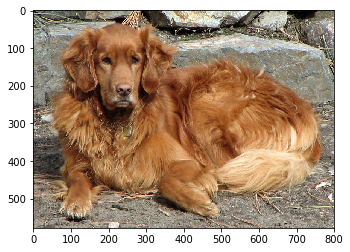

In [5]:
from PIL import Image
plt.imshow(Image.open(image_path))

In [6]:
ResNet50 = tf.keras.applications.ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input
image = tf.keras.preprocessing.image

In [7]:
resnet_model = ResNet50(weights='imagenet', include_top=False)

94658560/94653016 [==============================]94658560/94653016 [==============================] - 38s 0us/step

94666752/94653016 [==============================]94666752/94653016 [==============================] - 38s 0us/step



In [8]:
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return resnet_model.predict(x)[0][0][0]

In [9]:
f = extract_features(image_path)
print(f[:5])
print(len(f))

[0.03233024 0.05817406 0.37201637 0.         0.        ]
2048


In [118]:
small_out = image.load_img(image_path, target_size=(228, 228))

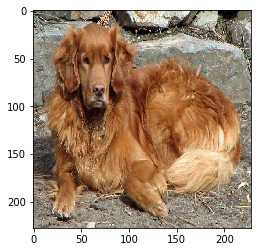

In [119]:
plt.imshow(small_out)

In [120]:
Input = tf.keras.layers.Input
Dense = tf.keras.layers.Dense
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D
UpSampling2D = tf.keras.layers.UpSampling2D
Model = tf.keras.models.Model
Reshape = tf.keras.layers.Reshape
#from tf.keras import backend as K

In [121]:
input_img = Input(shape=(128, ))  # adapt this if using `channels_first` image data format

x = Reshape([4, 4, 8] )(input_img)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [122]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [123]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 128)               0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_31 (UpSampling (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_32 (UpSampling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 16)        1168      
__________

In [124]:
TensorBoard = tf.keras.callbacks.TensorBoard

autoencoder.fit(np.array([f[:128]]), 
                #np.array([np.expand_dims(image.img_to_array(small_out), axis=0)]),
                np.reshape([image.img_to_array(small_out)], (1, 228, 228, 3)).astype('float32') / 255.,
                epochs=500,
               )
                #batch_size=128,
                #shuffle=True,
                #validation_data=(x_test, x_test),
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/500
1/1 [==============================]1/1 [==============================] - 1s 972ms/step - loss: 0.6988

Epoch 2/500
1/1 [==============================]1/1 [==============================] - 0s 148ms/step - loss: 0.6963

Epoch 3/500
1/1 [==============================]1/1 [==============================] - 0s 179ms/step - loss: 0.6947

Epoch 4/500
1/1 [==============================]1/1 [==============================] - 0s 182ms/step - loss: 0.6936

Epoch 5/500
1/1 [==============================]1/1 [==============================] - 0s 174ms/step - loss: 0.6928

Epoch 6/500
1/1 [==============================]1/1 [==============================] - 0s 162ms/step - loss: 0.6920

Epoch 7/500
1/1 [==============================]1/1 [==============================] - 0s 141ms/step - loss: 0.6911

Epoch 8/500
1/1 [==============================]1/1 [==============================] - 0s 141ms/step - loss: 0.6902

Epoch 9/500
1/1 [==============================]1/1 [===========


Epoch 71/500
1/1 [==============================]1/1 [==============================] - 0s 130ms/step - loss: 0.6517

Epoch 72/500
1/1 [==============================]1/1 [==============================] - 0s 136ms/step - loss: 0.6516

Epoch 73/500
1/1 [==============================]1/1 [==============================] - 0s 129ms/step - loss: 0.6515

Epoch 74/500
1/1 [==============================]1/1 [==============================] - 0s 127ms/step - loss: 0.6514

Epoch 75/500
1/1 [==============================]1/1 [==============================] - 0s 124ms/step - loss: 0.6513

Epoch 76/500
1/1 [==============================]1/1 [==============================] - 0s 114ms/step - loss: 0.6513

Epoch 77/500
1/1 [==============================]1/1 [==============================] - 0s 125ms/step - loss: 0.6512

Epoch 78/500
1/1 [==============================]1/1 [==============================] - 0s 124ms/step - loss: 0.6511

Epoch 79/500
1/1 [==============================]1/1 [=

1/1 [==============================]1/1 [==============================] - 0s 125ms/step - loss: 0.6468

Epoch 141/500
1/1 [==============================]1/1 [==============================] - 0s 114ms/step - loss: 0.6466

Epoch 142/500
1/1 [==============================]1/1 [==============================] - 0s 139ms/step - loss: 0.6470

Epoch 143/500
1/1 [==============================]1/1 [==============================] - 0s 133ms/step - loss: 0.6467

Epoch 144/500
1/1 [==============================]1/1 [==============================] - 0s 125ms/step - loss: 0.6471

Epoch 145/500
1/1 [==============================]1/1 [==============================] - 0s 116ms/step - loss: 0.6466

Epoch 146/500
1/1 [==============================]1/1 [==============================] - 0s 119ms/step - loss: 0.6469

Epoch 147/500
1/1 [==============================]1/1 [==============================] - 0s 127ms/step - loss: 0.6466

Epoch 148/500
1/1 [==============================]1/1 [=======


Epoch 209/500
1/1 [==============================]1/1 [==============================] - 0s 119ms/step - loss: 0.6432

Epoch 210/500
1/1 [==============================]1/1 [==============================] - 0s 113ms/step - loss: 0.6434

Epoch 211/500
1/1 [==============================]1/1 [==============================] - 0s 119ms/step - loss: 0.6430

Epoch 212/500
1/1 [==============================]1/1 [==============================] - 0s 124ms/step - loss: 0.6434

Epoch 213/500
1/1 [==============================]1/1 [==============================] - 0s 117ms/step - loss: 0.6429

Epoch 214/500
1/1 [==============================]1/1 [==============================] - 0s 116ms/step - loss: 0.6431

Epoch 215/500
1/1 [==============================]1/1 [==============================] - 0s 133ms/step - loss: 0.6425

Epoch 216/500
1/1 [==============================]1/1 [==============================] - 0s 170ms/step - loss: 0.6426

Epoch 217/500
1/1 [============================


Epoch 278/500
1/1 [==============================]1/1 [==============================] - 0s 144ms/step - loss: 0.6404

Epoch 279/500
1/1 [==============================]1/1 [==============================] - 0s 188ms/step - loss: 0.6397

Epoch 280/500
1/1 [==============================]1/1 [==============================] - 0s 155ms/step - loss: 0.6400

Epoch 281/500
1/1 [==============================]1/1 [==============================] - 0s 127ms/step - loss: 0.6395

Epoch 282/500
1/1 [==============================]1/1 [==============================] - 0s 116ms/step - loss: 0.6400

Epoch 283/500
1/1 [==============================]1/1 [==============================] - 0s 125ms/step - loss: 0.6392

Epoch 284/500
1/1 [==============================]1/1 [==============================] - 0s 126ms/step - loss: 0.6394

Epoch 285/500
1/1 [==============================]1/1 [==============================] - 0s 115ms/step - loss: 0.6387

Epoch 286/500
1/1 [============================


Epoch 347/500
1/1 [==============================]1/1 [==============================] - 0s 113ms/step - loss: 0.6359

Epoch 348/500
1/1 [==============================]1/1 [==============================] - 0s 134ms/step - loss: 0.6366

Epoch 349/500
1/1 [==============================]1/1 [==============================] - 0s 119ms/step - loss: 0.6365

Epoch 350/500
1/1 [==============================]1/1 [==============================] - 0s 144ms/step - loss: 0.6372

Epoch 351/500
1/1 [==============================]1/1 [==============================] - 0s 188ms/step - loss: 0.6363

Epoch 352/500
1/1 [==============================]1/1 [==============================] - 0s 212ms/step - loss: 0.6361

Epoch 353/500
1/1 [==============================]1/1 [==============================] - 0s 146ms/step - loss: 0.6356

Epoch 354/500
1/1 [==============================]1/1 [==============================] - 0s 127ms/step - loss: 0.6358

Epoch 355/500
1/1 [============================


Epoch 416/500
1/1 [==============================]1/1 [==============================] - 0s 152ms/step - loss: 0.6332

Epoch 417/500
1/1 [==============================]1/1 [==============================] - 0s 148ms/step - loss: 0.6328

Epoch 418/500
1/1 [==============================]1/1 [==============================] - 0s 153ms/step - loss: 0.6324

Epoch 419/500
1/1 [==============================]1/1 [==============================] - 0s 155ms/step - loss: 0.6320

Epoch 420/500
1/1 [==============================]1/1 [==============================] - 0s 153ms/step - loss: 0.6316

Epoch 421/500
1/1 [==============================]1/1 [==============================] - 0s 145ms/step - loss: 0.6315

Epoch 422/500
1/1 [==============================]1/1 [==============================] - 0s 163ms/step - loss: 0.6312

Epoch 423/500
1/1 [==============================]1/1 [==============================] - 0s 139ms/step - loss: 0.6314

Epoch 424/500
1/1 [============================


Epoch 485/500
1/1 [==============================]1/1 [==============================] - 0s 131ms/step - loss: 0.6292

Epoch 486/500
1/1 [==============================]1/1 [==============================] - 0s 133ms/step - loss: 0.6295

Epoch 487/500
1/1 [==============================]1/1 [==============================] - 0s 161ms/step - loss: 0.6290

Epoch 488/500
1/1 [==============================]1/1 [==============================] - 0s 150ms/step - loss: 0.6293

Epoch 489/500
1/1 [==============================]1/1 [==============================] - 0s 129ms/step - loss: 0.6295

Epoch 490/500
1/1 [==============================]1/1 [==============================] - 0s 156ms/step - loss: 0.6303

Epoch 491/500
1/1 [==============================]1/1 [==============================] - 0s 137ms/step - loss: 0.6307

Epoch 492/500
1/1 [==============================]1/1 [==============================] - 0s 149ms/step - loss: 0.6313

Epoch 493/500
1/1 [============================

In [126]:
decoded_img = autoencoder.predict(np.array([f[:128]]))
#plt.imshow(decoded_img.reshape(28, 28, 3))

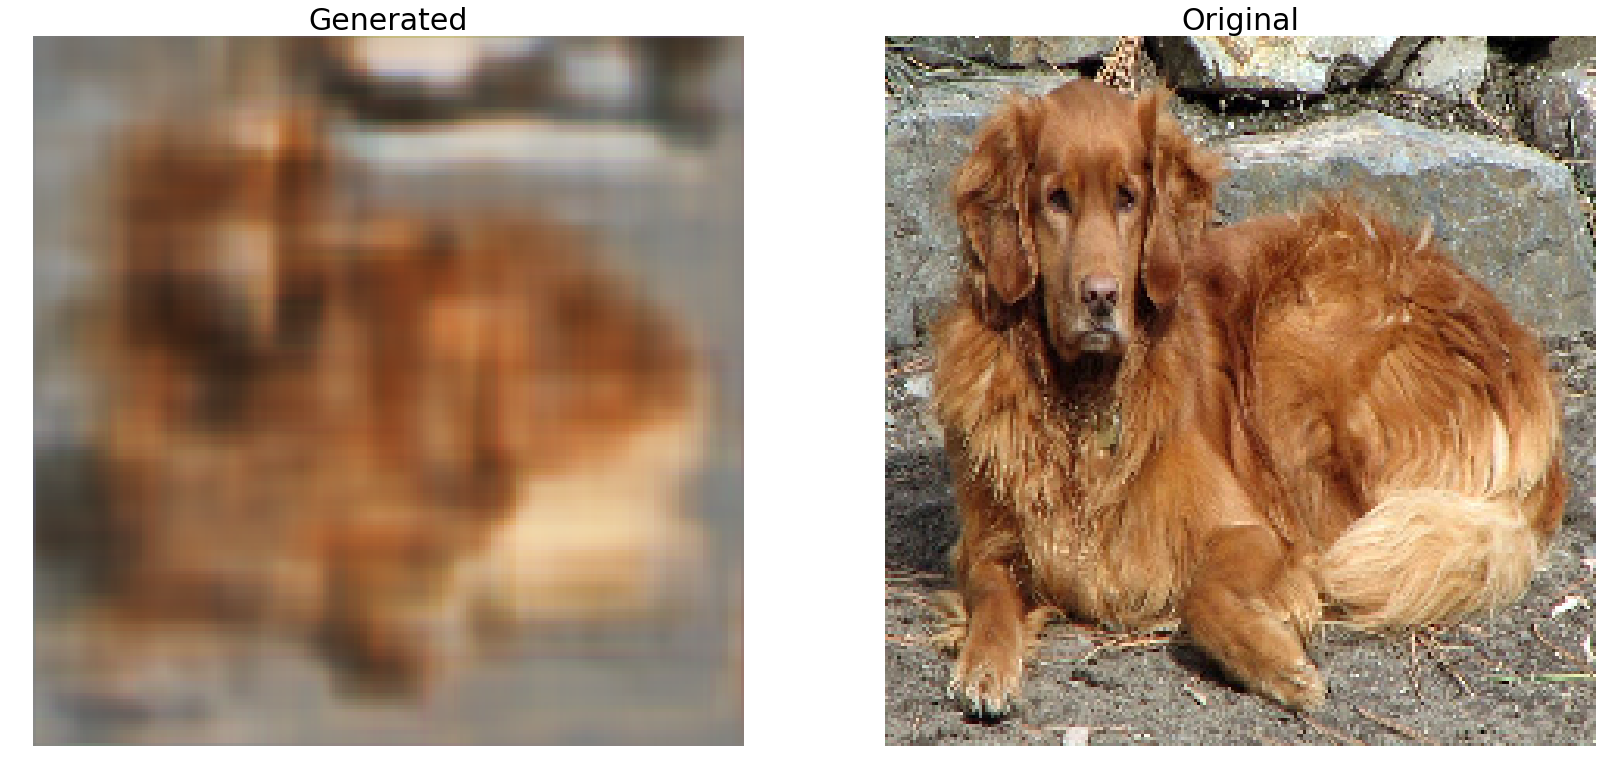

In [127]:
plt.figure(figsize=(28, 28))
plt.subplot(1, 2, 1)
plt.imshow(decoded_img.reshape(228, 228, 3))
plt.title('Generated', fontsize=30)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(small_out)
plt.title('Original', fontsize=30)
plt.axis('off')
#plt.tight_layout()
plt.show()

In [ ]:
1